# Heart Disease Prediction Analysis

# Introduction

This notebook presents an analysis of heart disease prediction using machine learning techniques. We utilize the Framingham Heart Study dataset to build and evaluate a logistic regression model for predicting the 10-year risk of coronary heart disease (CHD).

## Dataset Information

The Framingham Heart Study dataset contains information from a long-term cardiovascular study on residents of Framingham, Massachusetts. It includes various risk factors and the incidence of CHD over a 10-year period.

Link to data: https://www.kaggle.com/datasets/christofel04/cardiovascular-study-dataset-predict-heart-disea?select=train.csv

Key features in the dataset include:
- Demographic information (age, sex, education)
- Behavioral factors (smoking status, cigarettes per day)
- Medical history (BP medication, prevalent stroke, prevalent hypertension, diabetes)
- Physical measurements (total cholesterol, systolic BP, diastolic BP, BMI, heart rate, glucose)

Target variable:
- TenYearCHD: 10-year risk of CHD (0 = No, 1 = Yes)

## Objectives

1. Data Preprocessing: Clean and prepare the dataset for analysis.
2. EDA: Understand the distribution and relationships of variables.
3. Model Development: Build a logistic regression model to predict CHD risk.
4. Model Evaluation: Assess the model's performance using various metrics.
5. Optimization: If necessary, use methods to improve the model based on its classification metrics.
6. Results Interpretation: Analyze the model's predictions and discuss implications.



# 1. Data Preprocessing

In [ ]:
%%capture
! pip install Plotly
! pip install cufflinks
! pip install chart-studio

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import chart_studio.plotly as py
import cufflinks as cf
import seaborn as sns
import plotly.express as px
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [ ]:
df = pd.read_csv("/content/train.csv", index_col=0)

In [ ]:
df.shape

(3390, 16)

In [ ]:
df.head()

,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
id,,,,,,,,,,,,,,,,
0,64,2.0,F,YES,3.0,0.0,0,0,0,221.0,148.0,85.0,NaN,90.0,80.0,1
1,36,4.0,M,NO,0.0,0.0,0,1,0,212.0,168.0,98.0,29.77,72.0,75.0,0
2,46,1.0,F,YES,10.0,0.0,0,0,0,250.0,116.0,71.0,20.35,88.0,94.0,0
3,50,1.0,M,YES,20.0,0.0,0,1,0,233.0,158.0,88.0,28.26,68.0,94.0,1
4,64,1.0,F,YES,30.0,0.0,0,0,0,241.0,136.5,85.0,26.42,70.0,77.0,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3390 entries, 0 to 3389
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              3390 non-null   int64  
 1   education        3303 non-null   float64
 2   sex              3390 non-null   object 
 3   is_smoking       3390 non-null   object 
 4   cigsPerDay       3368 non-null   float64
 5   BPMeds           3346 non-null   float64
 6   prevalentStroke  3390 non-null   int64  
 7   prevalentHyp     3390 non-null   int64  
 8   diabetes         3390 non-null   int64  
 9   totChol          3352 non-null   float64
 10  sysBP            3390 non-null   float64
 11  diaBP            3390 non-null   float64
 12  BMI              3376 non-null   float64
 13  heartRate        3389 non-null   float64
 14  glucose          3086 non-null   float64
 15  TenYearCHD       3390 non-null   int64  
dtypes: float64(9), int64(5), object(2)
memory usage: 450.2+ KB


In [ ]:
df.isnull().sum()

,0
age,0
education,87
sex,0
is_smoking,0
cigsPerDay,22
BPMeds,44
prevalentStroke,0
prevalentHyp,0
diabetes,0
totChol,38


This shows that there are many columns with null values.

These can be handled either by dropping rows entirely or by using some sort of filling method.

A common filling method is mean/mode imputation. I decided not to use imputation as it would result in artificially decreased variance.

For columns such as "cigsPerDay", it is quite plausible that a NaN value simply means zero cigarretes, in which case filling NaNs with 0.0 would be appropriate. Since there is a column for "is_smoking" and also for "cigsPerDay", this hypothesis can be tested.

In [ ]:
df[["is_smoking","cigsPerDay"]][df["cigsPerDay"].isnull()]

,is_smoking,cigsPerDay
id,,
422,YES,NaN
466,YES,NaN
469,YES,NaN
491,YES,NaN
538,YES,NaN
767,YES,NaN
1461,YES,NaN
1467,YES,NaN
1597,YES,NaN


This showed that the rows which had NaN for cigsPerDay did not mean zero cigsPerDay. The data is simply missing.

The problem with simply dropping rows is that a lot of data will be lost. However I opted to use this method in the end due to the reasons above, and I will still have around 3000 rows of data remaining which is still a large dataset.

In [ ]:
df.dropna(inplace=True)

In [ ]:
df.shape

(2927, 16)

Encode the "sex" and "is_smoking" columns so that numerical analysis can be performed.

In [ ]:
df["sex"] = df["sex"].map(dict(M=1, F=0))
df["is_smoking"] = df["is_smoking"].map(dict(YES=1, NO=0))

In [ ]:
df.duplicated().any()

False

#EDA

I did some initial EDA to get an idea of which variables should be included in the regression model.

In [ ]:
df.describe()

,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
count,2927.000000,2927.000000,2927.000000,2927.000000,2927.000000,2927.000000,2927.000000,2927.000000,2927.000000,2927.000000,2927.000000,2927.000000,2927.000000,2927.000000,2927.000000,2927.000000
mean,49.507345,1.965494,0.446532,0.494363,9.112743,0.030065,0.006150,0.314315,0.026990,237.129142,132.626409,82.906218,25.797041,75.888282,81.934404,0.151691
std,8.597191,1.017199,0.497218,0.500054,11.882784,0.170795,0.078192,0.464322,0.162082,44.613282,22.326197,12.078873,4.130376,11.971207,24.106943,0.358783
min,32.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,113.000000,83.500000,48.000000,15.960000,45.000000,40.000000,0.000000
25%,42.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,117.000000,74.500000,23.030000,68.000000,71.000000,0.000000
50%,49.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,234.000000,128.500000,82.000000,25.380000,75.000000,78.000000,0.000000
75%,56.000000,3.000000,1.000000,1.000000,20.000000,0.000000,0.000000,1.000000,0.000000,264.000000,144.000000,90.000000,28.040000,83.000000,87.000000,0.000000
max,70.000000,4.000000,1.000000,1.000000,70.000000,1.000000,1.000000,1.000000,1.000000,600.000000,295.000000,142.500000,56.800000,143.000000,394.000000,1.000000


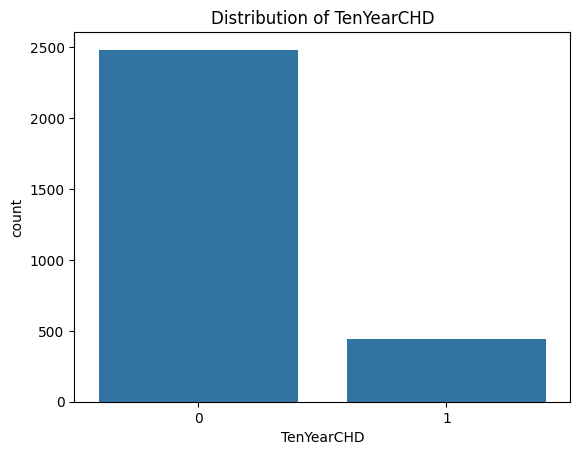

In [ ]:
sns.countplot(x='TenYearCHD', data=df)
plt.title('Distribution of TenYearCHD')
plt.show()

The target variable appears to be skewed with fewer positive cases compared to negative cases. This imbalance should be addressed during model training.

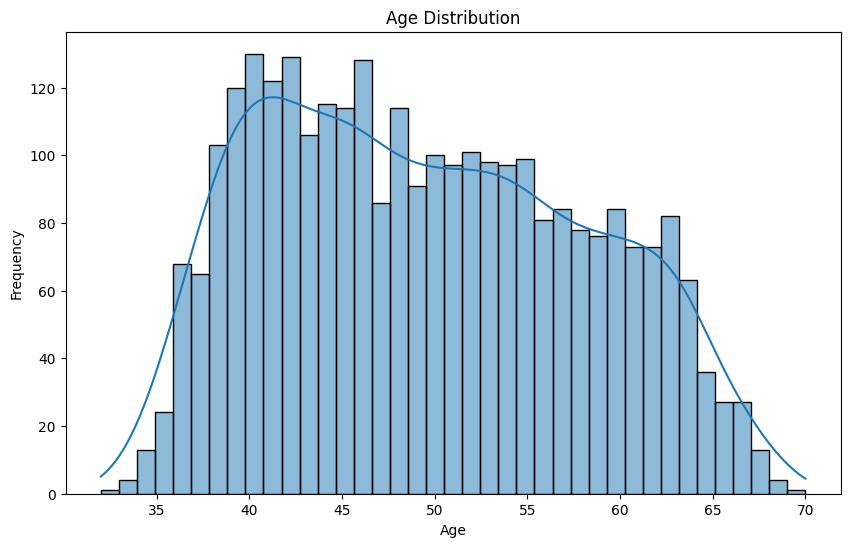

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df['age'], bins=39, kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

The age range is from 32 to 70. The ages show a normal distribution that is skewed towards the younger end.

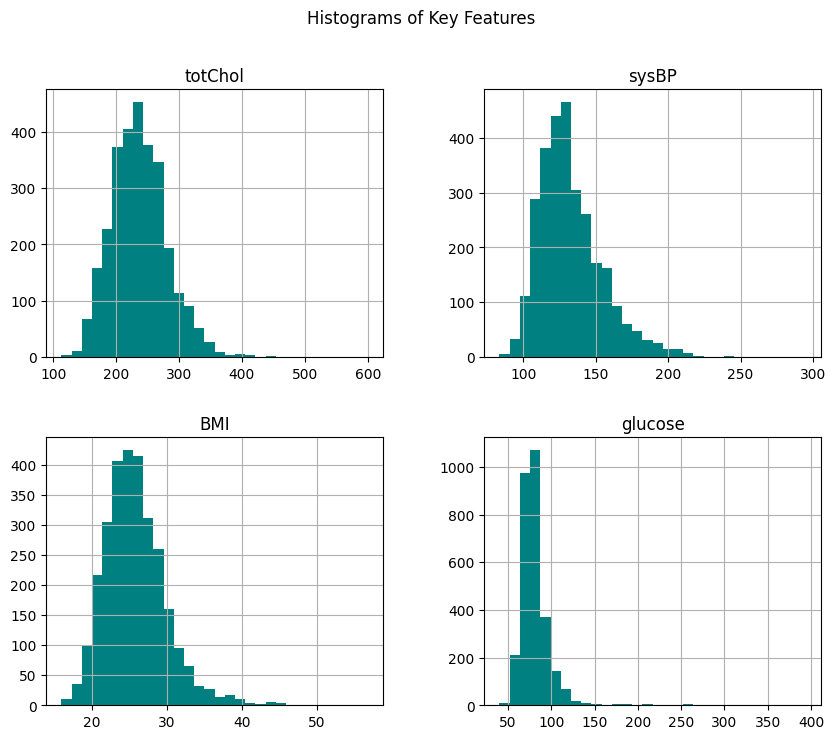

In [ ]:
df[['totChol', 'sysBP', 'BMI', 'glucose']].hist(bins=30, figsize=(10, 8), color='teal')
plt.suptitle('Histograms of Key Features')
plt.show()

The total cholesterol distribution shows a right skew, indicating that most individuals have cholesterol levels on the lower end, with fewer individuals having very high cholesterol levels.

The same shows for sysBP (Systolic Blood Pressure), BMI, and glucose.

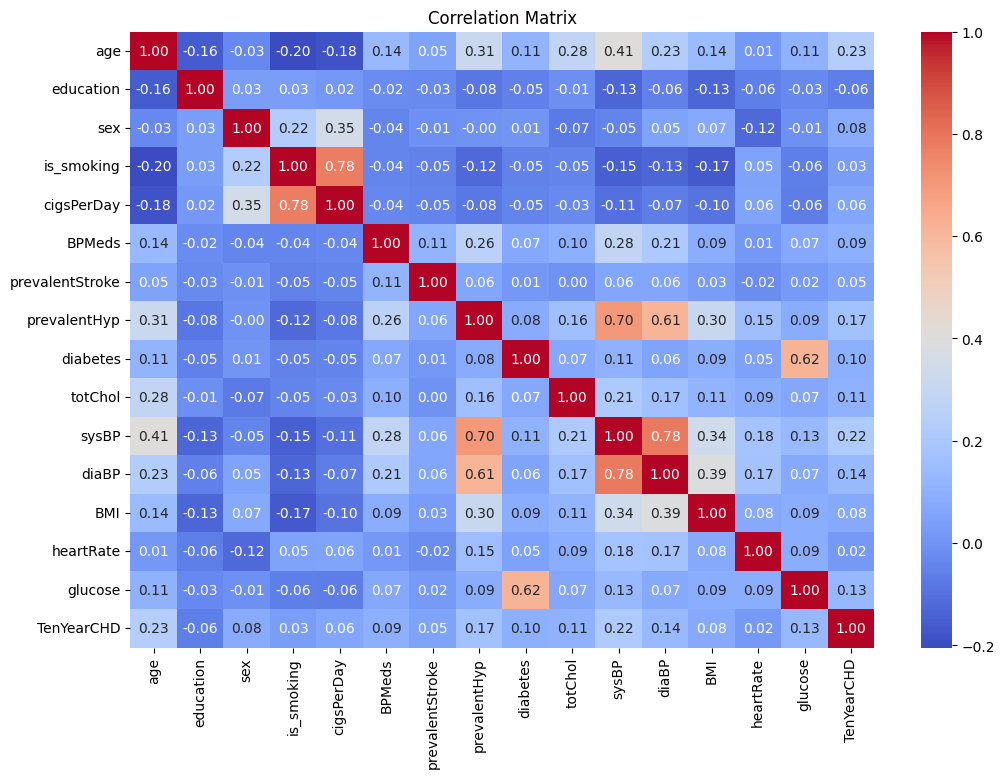

In [ ]:
corr_matrix = df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [ ]:
target_corr = corr_matrix['TenYearCHD'].sort_values(ascending=False)
print("Correlation with TenYearCHD:")
print(target_corr)

Correlation with TenYearCHD:
TenYearCHD         1.000000
age                0.234423
sysBP              0.217419
prevalentHyp       0.169136
diaBP              0.139005
glucose            0.133286
totChol            0.106473
diabetes           0.100006
BPMeds             0.092868
sex                0.081880
BMI                0.075950
cigsPerDay         0.059797
prevalentStroke    0.052014
is_smoking         0.033342
heartRate          0.018747
education         -0.062442
Name: TenYearCHD, dtype: float64


The strongest correlations relating to the target variable are:

Age with a correlation of 0.23

Systolic Blood Pressure with a correlation of 0.22

Prevalent Hypertension with a correlation of 0.17

The matrix also revealed a shockingly strong correlation between 'is_smoking' and 'cigsPerDay'.

It turns out people who identify as smokers tend to smoke!

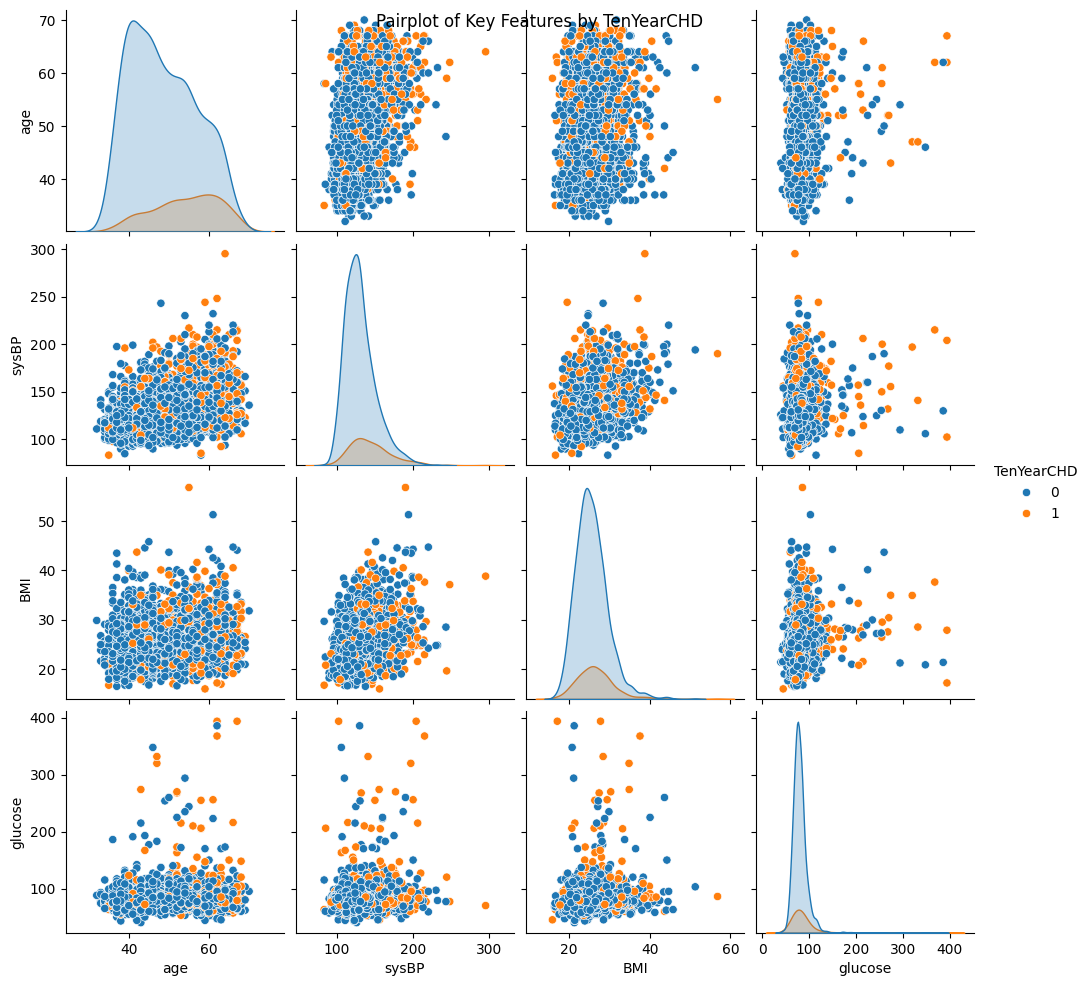

In [ ]:
sns.pairplot(df, vars=['age', 'sysBP', 'BMI', 'glucose'], hue='TenYearCHD')
plt.suptitle('Pairplot of Key Features by TenYearCHD')
plt.show()

From this EDA, age, sysBP and prevalentHyp all seem like they are features that should be included in the regression model.

Also, from research and general domain knowledge, cigsPerDay, BMI, diabetes,  and totChol are commonly associated with CHD risk. It is also known that men generally have a higher CHD risk than women.

#Logistic Regression

Separate the features and the target variable.

In [ ]:
target = 'TenYearCHD'
features = ['age', 'sex', 'cigsPerDay', 'BPMeds',
            'prevalentHyp', 'diabetes', 'totChol', 'sysBP', 'diaBP', 'BMI',
            'heartRate', 'glucose']

X = df[features]
y = df[target]

Split the dataset.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Introduce the StandardScaler() class.

This allows us to call the scaler.fit() and scaler.transform() methods.

The main idea is to standardize the features before applying any machine learning model. (i.e. make μ = 0 and σ = 1)

In more detail, scaler.fit() computes the μ and σ of the raw features.

Then, scaler.transform() uses the μ and σ to perform standardisation of the raw features by centering and scaling them.

fit_transform() is just both of these turned into a single operation.

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Introduce the LogisticRegression() class.

This allows us to call the log_reg.fit() method.

Fitting the model to the training data is essentially the training part of the modeling process. It finds the coefficients for the logistic regression equation.

In [ ]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

LogisticRegression()

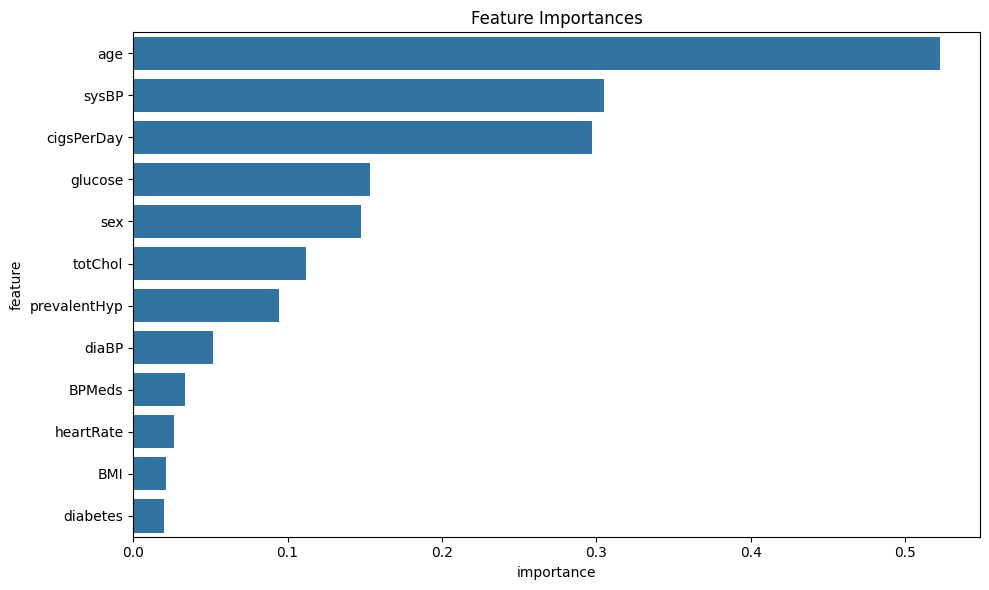

In [ ]:
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': abs(log_reg.coef_[0])})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importances')
plt.tight_layout()

Printing the actual coefficient values out:

In [ ]:
for feature, coef in zip(X.columns, log_reg.coef_[0]):
    print(f"{feature}: {coef:.4f}")

age: 0.5223
sex: 0.1473
cigsPerDay: 0.2972
BPMeds: 0.0334
prevalentHyp: 0.0947
diabetes: 0.0202
totChol: 0.1121
sysBP: 0.3048
diaBP: -0.0518
BMI: 0.0211
heartRate: -0.0265
glucose: 0.1536


Now that the model has been trained, it can be used to make predictions.

In [ ]:
y_pred = log_reg.predict(X_test)

The percentage of CHD results that our model successfully predicted is represented by accuracy.

Using various train vs test splits of the dataset will generally give an accuracy score of around 0.85.

This means that the model correctly predicts someone's CHD status 85% of the time.

In [ ]:
accuracy_score(y_test, y_pred)

0.863481228668942

Now create a confusion matrix.

True Negative (Top-Left Quadrant)

False Positive (Top-Right Quadrant)

False Negative (Bottom-Left Quadrant)

True Positive (Bottom-Right Quadrant)

In [ ]:
cm = confusion_matrix(y_test, y_pred)

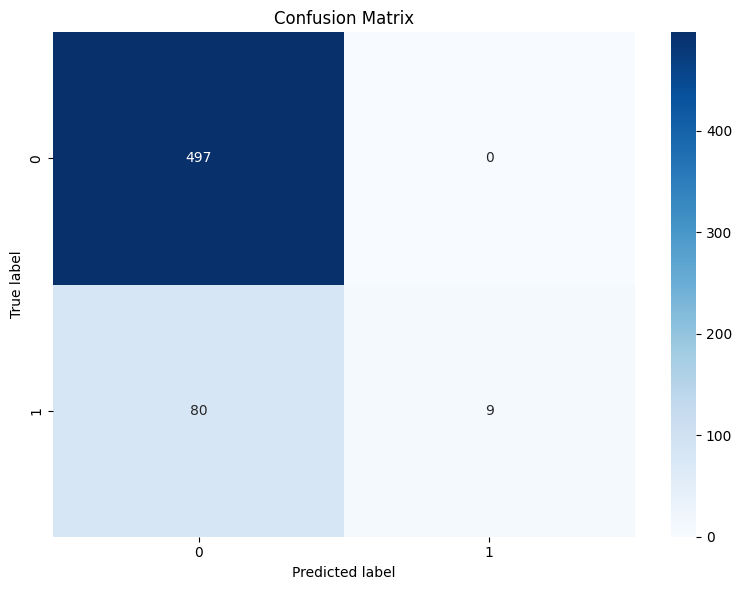

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      1.00      0.93       497
           1       1.00      0.10      0.18        89

    accuracy                           0.86       586
   macro avg       0.93      0.55      0.55       586
weighted avg       0.88      0.86      0.81       586



Some classification metrics of importance are accuracy, precision and recall.

Let's consider the value of each for the present data.

As noted above, the model achieves an accuracy of about 85% on test sets. However, it's important to note that there is a high imbalance of classes. In the data there are far more cases of not having CHD than having CHD. Therefore, a broken model that simply always predicted not having CHD would have quite a high accuracy. Therefore accuracy may not be the best classification metric for this data.

Precision answers the question: how often the positive predictions are correct? Above we can see that for the case of people having CHD, the precision is high. This means that all times the model says someone has CHD, they did indeed have CHD. This is good if the cost of a false positive is high, but precision does not consider false negatives.

This is a major problem in our case because, in the context of medical dignosis, a false positive can lead to wasted time and money, however a false negative can result in death. Therefore the cost of a false negative is much worse than the cost of a false positive.

Recall measures how often the model correctly identifies positive instances. This means the recall score will be low if there are a lot of false negatives. Above we can see that for the positve case we have a low recall. This means that the model performs much better in predicting if someone **doesn't** have CHD than in predicting if someone **does** have CHD. I.e. the model is prone to false negatives.

In the present case, recall is the most appropriate metric to use for assessing the effectiveness of the model. And since our recall is low, our model is not currently effective.

#New classification threshold

The default classification threshold is 0.5 which means that if the model determines a patient has a >50% probablity of CHD, the model will classify them as being CHD positive.

However, We want to minimize the risk of missing potential CHD cases, even if it means increasing false positives to some extent. We can adjust the classification threshold to achieve this. A safer option would be to have a threshold of 0.1. Meaning that if the model determines that someone has only a >10% probability of CHD, they will be classified as CHD positve.

The predict_proba() method returns an array with columns representing the predicted probabilities for each class. In this case the first column is the probability of being CHD negative for each row, and the second column is the probability of CHD positive for each row.

We can use list slicing to get all the CHD positive probabilities.

In [ ]:
y_pred_probabilities = log_reg.predict_proba(X_test)[:,1]

Turn the entire array of probabilities into a Boolean Mask where True is returned if the probability is more than 0.1

Instead of True/False, make it 1/0.

In [ ]:
new_threshold = 0.1
y_pred_new_threshold = (y_pred_probabilities >= new_threshold).astype(int)

In [ ]:
print(classification_report(y_test, y_pred_new_threshold))

              precision    recall  f1-score   support

           0       0.97      0.46      0.62       497
           1       0.23      0.91      0.37        89

    accuracy                           0.53       586
   macro avg       0.60      0.68      0.49       586
weighted avg       0.85      0.53      0.58       586



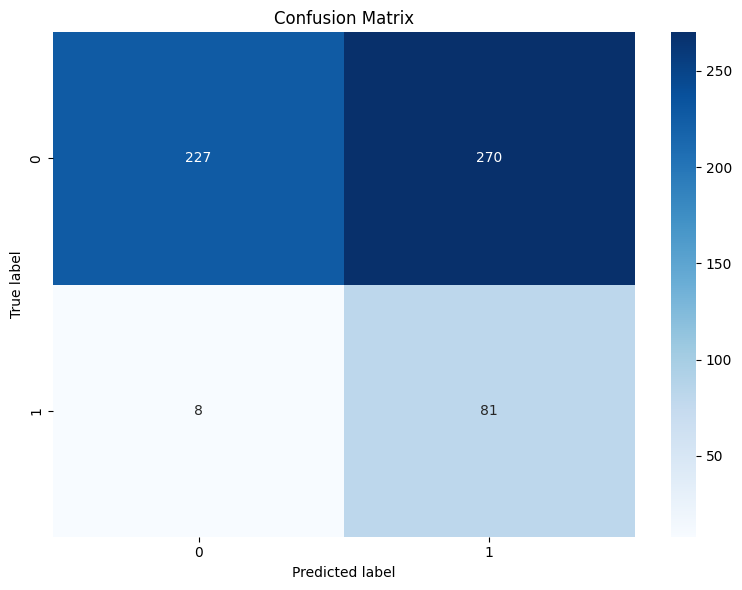

In [ ]:
cm_new = confusion_matrix(y_test, y_pred_new_threshold)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_new, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

It can be seen that while the accuracy of the model is reduced, there are far less dangerous occurences of false negatives when it comes to predicting if someone has CHD.

##Analysis of Model and Implications

The logistic regression model developed in this analysis provides valuable insights into predicting the 10-year risk of CHD. The first model demonstrated strong performance in identifying non-CHD cases, achieving high precision and accuracy. However, it struggled with detecting CHD cases, as evidenced by lower recall rates.

By adjusting the classification threshold, we were able to significantly improve recall for CHD cases, capturing a larger proportion of true positives. This adjustment, however, comes at the cost of increased false positives, which may lead to unnecessary medical interventions or anxiety for individuals incorrectly identified as at risk.

These findings highlight the importance of balancing precision and recall based on the specific context and consequences of false positives and negatives. In clinical settings, where missing a true CHD case could have severe implications, prioritizing recall might be more appropriate.

# Summary and Conclusions

In this analysis, we explored the prediction of CHD risk using logistic regression. Here's a summary of the key steps and findings:

## Main Findings

1. **Data Preprocessing**: Successfully cleaned and prepared the dataset, handling missing values and scaling features for model training.

2. **EDA**: Performed some EDA to get determine which features would be most relevant to the model.

3. **Model Development**: Built a logistic regression model to predict the 10-year risk of CHD.

4. **Model Evaluation**: Evaluated the model using various metrics, including accuracy, precision, recall, and F1-score.
   - The model showed good performance in predicting non-CHD cases but struggled with CHD cases.

5. **Threshold Optimization**: Explored different classification thresholds to improve recall for CHD cases.
   - Lowering the threshold to 0.1 significantly increased recall for CHD cases, but at the cost of precision.

6. **Results Interpretation**: Analyzed the confusion matrices and classification reports to understand the trade-offs between precision and recall.

## Insights

- The logistic regression model is effective in identifying non-CHD cases but requires threshold adjustments to improve CHD case detection.
- Lowering the threshold can help catch more CHD cases, but it increases false positives. A preferable trade-off.

## Suggestions for Further Analysis

1. **Feature Engineering**: Explore additional features or transformations that might improve model performance.

2. **Advanced Models**: Consider using more complex models like Random Forests to capture non-linear relationships.

3. **Cross-Validation**: Implement cross-validation to ensure the model's robustness and generalizability.

4. **Threshold Tuning**: Further explore threshold tuning using techniques like ROC curve analysis to find the optimal balance between precision and recall.